In [2]:
!pip install ultranest rebound
!git clone https://github.com/rzellem/EXOTIC
%cd EXOTIC
!git checkout tess
%cd ..
import sys
sys.path.append("F:/EXOTIC")

!git clone https://github.com/pearsonkyle/Nbody-AI
sys.path.append('F:/Nbody-AI/nbody')

sys.path.insert(0, 'F:/Nbody-AI')

F:\EXOTIC


fatal: destination path 'EXOTIC' already exists and is not an empty directory.
C:\Users\vikas\AppData\Local\anaconda3\envs\nbody\Lib\site-packages\IPython\core\magics\osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


M	exotic/api/nested_linear_fitter.py
Your branch is up to date with 'origin/tess'.
F:\


Already on 'tess'
fatal: destination path 'Nbody-AI' already exists and is not an empty directory.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from nbody.simulation import generate, analyze, report
from nbody.tools import mjup, msun, mearth, G, au
import pickle

# Define paths for storing data and results
plot_dir = "E:/SIMS9400/TTV_Plots"
data_dir = "E:/SIMS9400/TTV_Data"
report_dir = "E:/SIMS9400/Report_Plots"  # New directory for report plots
frequency_dir = "E:/SIMS9400/Frequency_Plots"  # New directory for report plots
params_dir = "E:/SIMS9400/params"

os.makedirs(plot_dir, exist_ok=True)
os.makedirs(data_dir, exist_ok=True)
os.makedirs(report_dir, exist_ok=True)
os.makedirs(frequency_dir, exist_ok=True)
os.makedirs(params_dir, exist_ok=True)


# Hill radius function
def hill_radius(a, e, m, m_star):
    """Calculates the Hill radius of a planet."""
    return a * (1 - e) * (m / (3 * m_star))**(1/3)

def mutual_hill_radius(a1, a2, m1, m2, m_star):
    """
    Computes the mutual Hill radius for two planets.
    
    Parameters
    ----------
    a1 : float
        Semi-major axis of planet 1 (same length units as a2).
    a2 : float
        Semi-major axis of planet 2.
    m1 : float
        Mass of planet 1 (in the same mass units as m_star).
    m2 : float
        Mass of planet 2.
    m_star : float
        Stellar mass.
    
    Returns
    -------
    float
        Mutual Hill radius in the same distance units as a1, a2.
    """
    a_mean = 0.5 * (a1 + a2)
    return np.abs(a_mean * ((m1 + m2) / (3.0 * m_star))**(1/3))

# Generate system parameters with customizable properties
def generate_simulation_with_custom_params(type_to_change, values, period_ratio=None, mass_ratio=None):
    """Generates parameters for a planetary system, allowing customization of specific properties."""
    # Default parameters
    stellar_mass = 1 * msun / msun  # Fixed at 0.5 M_sun
    inner_mass = 1 * mearth / msun  # Default: 1 M_earth / M_sun
    outer_mass = 1 * mearth / msun  # Default: 5 M_earth / M_sun
    inner_period = 2.5  # Default inner period
    outer_period = 5.25  # Default outer period
    inner_eccentricity = 0
    inner_inclination = 90
    outer_eccentricity = 0
    outer_inclination = 90
    inner_omega = 0
    outer_omega = 0

    # Dynamically apply parameter changes
    if type_to_change == "inner_mass":
        inner_mass = values * mearth / msun
    elif type_to_change == "outer_mass":
        outer_mass = values * mearth / msun
    elif type_to_change == "stellar_mass":
        stellar_mass = values
    elif type_to_change == "inner_period":
        inner_period = values
    elif type_to_change == "outer_period":
        outer_period = values
    elif type_to_change == "inner_eccentricity":
        inner_eccentricity = values
    elif type_to_change == "outer_eccentricity":
        outer_eccentricity = values
    elif type_to_change == "inner_inclination":
        inner_inclination = values
    elif type_to_change == "outer_inclination":
        outer_inclination = values
    elif type_to_change == "inner_omega":
        inner_omega = values
    elif type_to_change == "outer_omega":
        outer_omega = values
    elif type_to_change == "period_ratio":
        # Update outer_period based on the provided period_ratio
        outer_period = inner_period * values

    elif type_to_change == "mass_ratio":
        # Update outer_period based on the provided period_ratio
        outer_mass = inner_mass * values

        #print(f"Inner Mass: {inner_mass}, Mass Ratio: {values}, Outer Mass: {outer_mass}")

    inner_a_m = (inner_period**2 * G * stellar_mass*msun / (4.0 * np.pi**2))**(1/3)
    outer_a_m = (outer_period**2 * G * stellar_mass*msun / (4.0 * np.pi**2))**(1/3)

    # Convert from meters to AU for convenience
    inner_a = inner_a_m / au
    outer_a = outer_a_m / au

    # Compute the mutual Hill radius
    R_H_m = mutual_hill_radius(inner_a, outer_a, inner_mass, outer_mass, stellar_mass)

    # Eccentricity-based "closest approach" difference
    delta_a_eff = np.abs((outer_a * (1.0 - outer_eccentricity)) - (inner_a * (1.0 + inner_eccentricity)))

    if R_H_m != 0:
        hill_ratio = delta_a_eff / R_H_m
    else:
        hill_ratio = None  # or float('inf') if R_H_m=0 is an edge case

    # Our threshold factor
    K = 5

    # Check for negative or insufficient separation
    if np.abs(delta_a_eff) < np.abs(K * R_H_m):
        raise ValueError(
            f"Orbits potentially unstable: effective separation is {delta_a_eff:.4g} AU, "
            f"which is < K * R_H_m = {K * R_H_m:.4g} AU. "
            f"(Inner e={inner_eccentricity}, Outer e={outer_eccentricity})"
        )
        
    return {
        'stellar_mass': stellar_mass,
        'inner_mass': inner_mass,
        'inner_period': inner_period,
        'inner_eccentricity': inner_eccentricity,
        'inner_inclination': inner_inclination,
        'inner_a': inner_a / au,
        'outer_mass': outer_mass,
        'outer_period': outer_period,
        'outer_eccentricity': outer_eccentricity,
        'outer_inclination': outer_inclination,
        'outer_a': outer_a / au,
        'period_ratio': period_ratio,
        'inner_omega': inner_omega,
        'outer_omega': outer_omega,

        'Mutual_Hill_Radius': R_H_m,
        'Effective_Separation': delta_a_eff,
        'Hill_Ratio': hill_ratio
    }


# Simulate TTV data
def simulate_ttv(objects, epochs, inner_period):
    """Simulates TTV curves using N-body dynamics."""
    total_time = epochs * inner_period
    sim_data = generate(objects, total_time, int(epochs*100), integrator='ias15')  # Simulate in minutes
    ttv_data = analyze(sim_data)

    #save_frequency_and_period_plots(ttv_data, simulation_id=0, plot_dir=report_dir)  # Save frequency and period plots
    #print("TTV curve generated")
    return ttv_data

# Save report plots
def save_report_plot(ttv_data, simulation_id, report_dir):
    """Saves a report plot for the given TTV data."""
    file = os.path.join(report_dir, f"ttv_report_plot{simulation_id}.png")
    report(ttv_data, savefile=file)
   
    #print(f"Report plot saved to {file}")
    plt.close()



from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter1d
import numpy as np
import os
import matplotlib.pyplot as plt
import csv

from scipy.signal import find_peaks, peak_widths
import numpy as np
import os
import matplotlib.pyplot as plt
import csv
from astropy.timeseries import LombScargle

def lomb_scargle(t, y, dy=None, minfreq=1./365, maxfreq=1/2, npeaks=0, peaktol=0.05):
    """
    A custom Lomb-Scargle function (exact signature).
    Calls the astropy LombScargle and returns frequency, power arrays.

    Parameters
    ----------
    t : array-like
        Time array (e.g., epochs or days).
    y : array-like
        Observed values (e.g., TTV, zero-centered).
    dy : array-like or None
        Uncertainties for y. If None, the unweighted Lomb-Scargle is used.
    minfreq : float
        Minimum frequency for the periodogram.
    maxfreq : float
        Maximum frequency for the periodogram.
    npeaks : int
        Unused here, but kept for signature consistency.
    peaktol : float
        Unused here, but kept for signature consistency.

    Returns
    -------
    frequency : numpy.ndarray
        Frequencies scanned by LombScargle.
    power : numpy.ndarray
        Power at each frequency.
    """
    if isinstance(dy, np.ndarray):
        ls = LombScargle(t, y, dy)
    else:
        ls = LombScargle(t, y)

    frequency, power = ls.autopower(
        minimum_frequency=minfreq,
        maximum_frequency=maxfreq,
        samples_per_peak=10
    )
    return frequency, power


def save_frequency_and_period_plots(ttv_data, simulation_id, plot_dir, planet_index, fap_threshold=0.01):
    """
    Plots and saves the frequency, period plots, and Fourier Transform for a specific simulation.
    Identifies and saves peak information to a CSV without smoothing the power spectrum.

    Parameters:
    - ttv_data (dict): The TTV data from simulation.
    - simulation_id (int): Simulation identifier.
    - plot_dir (str): Directory where the plots will be saved.
    - planet_index (int): Index of the planet (0 or 1).

    Returns:
    - dominant_period (float): The most dominant period.
    - second_dominant_period (float): The second most dominant period.
    - power_dominant (float): Power of the most dominant period.
    - power_second_dominant (float): Power of the second most dominant period.
    """

    second_dominant_period = -99999
    dominant_period = -99999
    power_dominant = -99999
    power_second_dominant = -99999
    #frequencies = ttv_data['planets'][planet_index]['freq']
    #power = ttv_data['planets'][planet_index]['power']

    
    ttv_curve = ttv_data['planets'][planet_index]['ttv'] * 24 * 60  # Convert days to minutes
    epochs = np.arange(1, len(ttv_curve) + 1)
    plt.plot(epochs, ttv_curve)

    time_array = epochs  # or a more precise time if you have it
    values = ttv_curve   # TTV in e.g. minutes, but can be in days. Just keep units consistent.

    ls = LombScargle(time_array, values)
    frequencies, power = lomb_scargle(
        t=epochs,
        y=values,
        dy=None,                # or pass an array of uncertainties if you have it
        minfreq=1./365,         # default per your snippet
        maxfreq=1/2,            # default per your snippet
        npeaks=0,
        peaktol=0.05
    )
   
    periods = 1 / np.array(frequencies)  # Convert frequencies to periods
    plt.plot(periods, power)

    # If your TTV curve is small or has a non-zero mean, 
    # sometimes people subtract the mean. Not strictly required.
    values -= np.mean(values)
    

    height = 0.01
    # Identify peaks with prominence and distance filtering
        # Identify peaks with prominence and distance filtering
    peaks, properties = find_peaks(
        power,
        height=height,          # Minimum height
        prominence=height/5,     # Minimum prominence
        distance=5              # Minimum distance between peaks
    )
   
    # If no peaks are found, find the two highest peaks regardless of height/prominence
    if len(peaks) == 0:
        sorted_indices = np.argsort(power)[::-1]  # Descending order of power
        peaks = sorted_indices[:2]  # Get the two highest peaks
        peak_periods = periods[peaks]
        peak_powers = power[peaks]
       # print("No peaks found with height and prominence criteria; using two highest peaks instead.")
    else:
        peak_periods = periods[peaks]
        peak_powers = power[peaks]
   
    # If only one peak is found, we need to handle that case
    if len(peaks) == 1:
        second_dominant_period = peak_periods[0]  # Use the same peak as the second dominant
        power_second_dominant = peak_powers[0]   # Same power for second dominant
        #print("Only one peak found; using the same peak as both dominant and second dominant.")
    else:
        # Calculate plateau widths of the peaks
        widths = peak_widths(power, peaks, rel_height=0.5)
        widths_at_half_height = widths[0]

        # Save peak data to CSV
        csv_filename = os.path.join(plot_dir, f"peak_data_sim_{simulation_id}_planet_{planet_index}.csv")
        with open(csv_filename, mode='w', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(["Peak Index", "Period", "Power", "Width (Plateau)", "Prominence"])
            for i, (period, peak_power, width, prom) in enumerate(zip(
                    peak_periods, peak_powers, widths_at_half_height, properties.get("prominences", [None]*len(peaks))
            )):
                writer.writerow([i + 1, period, peak_power, width, prom])
        #print(f"Peak data saved to {csv_filename}")

        # Sort peaks by power
        sorted_indices = np.argsort(peak_powers)[::-1]  # Descending order of power
        dominant_period = peak_periods[sorted_indices[0]]
        power_dominant = peak_powers[sorted_indices[0]]

        # Find the second dominant period that is distinct
        second_dominant_period = None
        power_second_dominant = None
        for idx in sorted_indices[1:]:
            if abs(peak_periods[idx] - dominant_period) > 0.05 * dominant_period:  # Relaxed threshold
                second_dominant_period = peak_periods[idx]
                power_second_dominant = peak_powers[idx]
                break
               

        # If no distinct second dominant period is found, default to the second-highest peak
        if second_dominant_period is None:
            second_dominant_period = -999
            power_second_dominant = -999

        if dominant_period is None:
            dominant_period = -999
            power_dominant = -999

        if power_dominant is None:
            dominant_period = -999
            power_dominant = -999
           
    # For the best peak, we check FAP
    # Only do this if we have a valid peak
    dominant_signal_pass = 'Yes'
    if dominant_period > 0 and power_dominant > 0:
        # We can get the amplitude at that peak:
        # pass it to false_alarm_probability
        # The LombScargle doc requires the power itself
        # e.g. fap = ls.false_alarm_probability(power_dominant, method='baluev')
        try:
            fap_val = ls.false_alarm_probability(power_dominant)
            if fap_val < fap_threshold:
                dominant_signal_pass = 'No'
        except Exception:
            # fallback
            fap_val = 999.0
    else:
        fap_val = 999.0

    dominant_signal_pass = 'Yes'
    if dominant_period > 0 and power_dominant > 0:
        try:
            fap_dominant = ls.false_alarm_probability(power_dominant)
            if fap_dominant < fap_threshold:
                dominant_signal_pass = 'No'
        except Exception:
            fap_dominant = 999.0
    else:
        fap_dominant = 999.0

    # Next, we also want to store *all* peaks that pass the FAP test
    # We'll create a separate CSV for all peaks
    # We'll do one row per peak: freq, period, power, FAP, pass
    all_peaks_csv = os.path.join(plot_dir, f"peak_data_fap_sim_{simulation_id}_planet_{planet_index}.csv")
    with open(all_peaks_csv, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["PeakIndex", "Frequency", "Period", "Power", "FAP", f"FAP<{fap_threshold}?"])
        for i, pk_idx in enumerate(peaks):
            freq_i = frequencies[pk_idx]
            per_i = periods[pk_idx]
            pow_i = power[pk_idx]
            try:
                fap_i = ls.false_alarm_probability(pow_i)
            except Exception:
                fap_i = 999.0
            pass_boolean = (fap_i < fap_threshold)
            writer.writerow([i+1, freq_i, per_i, pow_i, fap_i, pass_boolean])
            
    # Frequency plot
    plt.figure(figsize=(10, 6))
    plt.plot(frequencies, power, label="Frequency Data")
    plt.scatter(frequencies[peaks], power[peaks], color='orange', label="Peaks")
    plt.title(f"Frequency Plot - Simulation {simulation_id} - Planet {planet_index}")
    plt.xlabel("Frequency")
    plt.ylabel("Power")
    plt.legend()
    freq_plot_filename = os.path.join(plot_dir, f"frequency_plot_sim_{simulation_id}_planet_{planet_index}.png")
    plt.savefig(freq_plot_filename)
    #print(f"Frequency plot of planet {planet_index} saved to {freq_plot_filename}")
    plt.close()

    # Period plot
    plt.figure(figsize=(10, 6))
    plt.plot(periods, power, label="Period Data")
    plt.scatter(peak_periods, peak_powers, color='orange', label="Peaks")
    plt.scatter([dominant_period], [power_dominant], color='red', s=100, label=f"Dominant Period: {round(dominant_period, 3)}")
    if second_dominant_period:
        plt.scatter([second_dominant_period], [power_second_dominant], color='blue', s=100, label=f"Second Dominant: {round(second_dominant_period, 3)}")
    plt.title(f"Period Plot - Simulation {simulation_id} - Planet {planet_index}")
    plt.xlabel("Period (epochs)")
    plt.ylabel("Power")
    plt.legend()
    period_plot_filename = os.path.join(plot_dir, f"period_plot_sim_{simulation_id}_planet_{planet_index}.png")
    plt.savefig(period_plot_filename)
    #print(f"Period plot of planet {planet_index} saved to {period_plot_filename}")
    plt.close()

    # Fourier Transform of TTV Curve
    fft_result = np.fft.fft(ttv_curve)
    fft_frequencies = np.fft.fftfreq(len(ttv_curve), d=epochs[1] - epochs[0])
    fft_amplitudes = np.abs(fft_result)

    # Save Fourier Transform data
    # Save Fourier Transform data
    fft_csv_filename = os.path.join(plot_dir, f"fft_data_sim_{simulation_id}_planet_{planet_index}.csv")
    with open(fft_csv_filename, mode='w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["Frequency", "Amplitude", "Period (1/Frequency)"])
        for freq, amp in zip(fft_frequencies, fft_amplitudes):
            if freq == 0:
                period = float('inf')  # Infinite period for zero frequency
            else:
                period = 1 / freq
            writer.writerow([freq, amp, period])
    #print(f"Fourier Transform data with periods saved to {fft_csv_filename}")


    # Plot Fourier Transform (Amplitude Spectrum)
    plt.figure(figsize=(10, 6))
    plt.plot(fft_frequencies[:len(fft_frequencies)//2], fft_amplitudes[:len(fft_amplitudes)//2], label="FFT Amplitude Spectrum")
    plt.title(f"Fourier Transform - Simulation {simulation_id} - Planet {planet_index}")
    plt.xlabel("Frequency (1/epochs)")
    plt.ylabel("Amplitude")
    plt.legend()
    fft_plot_filename = os.path.join(plot_dir, f"fft_plot_sim_{simulation_id}_planet_{planet_index}.png")
    plt.savefig(fft_plot_filename)
    #print(f"Fourier Transform plot of planet {planet_index} saved to {fft_plot_filename}")
    plt.close()

    #print(f"Dominant period of planet {planet_index}: {dominant_period} with power {power_dominant}")
    #if second_dominant_period:
        #print(f"Second dominant period of planet {planet_index}: {second_dominant_period} with power {power_second_dominant}")

    return dominant_period, second_dominant_period, power_dominant, power_second_dominant, dominant_signal_pass, fap_dominant

def find_power_at_synodic_period(frequencies, power, planet_period, synodic_period):
    """
    Finds the power at the given synodic period in the power spectrum.

    Parameters:
    - frequencies (numpy.ndarray): Array of frequencies from the power spectrum.
    - power (numpy.ndarray): Array of power values corresponding to the frequencies.
    - synodic_period (float): The synodic period in days.

    Returns:
    - power_at_synodic (float): The power at the synodic period.
    """
    # Convert synodic period to frequency
    synodic_periodn = synodic_period/planet_period
    synodic_frequency = 1 / synodic_periodn

    # Find the closest frequency in the spectrum
    closest_index = np.argmin(np.abs(frequencies - synodic_frequency))
    power_at_synodic = power[closest_index]

    return power_at_synodic

def plot_ttv_curve(ttv_data, simulation_id, plot_dir, parameter_name, parameter_value, unit="", planet_index=0, amplitude=None, periodicity=None):
    """
    Plots and saves the TTV curve for a specific simulation.

    Parameters:
    - ttv_data: The TTV data dictionary from simulation.
    - simulation_id: ID of the simulation for labeling.
    - plot_dir: Directory where the plot will be saved.
    - parameter_name: Name of the parameter varied in the simulation.
    - parameter_value: Value of the parameter varied in the simulation.
    - unit: Optional unit of the parameter value.
    - planet_index: Index of the planet (default is 0 for the first planet).
    - amplitude: TTV amplitude to display on the plot (optional).
    - periodicity: Dominant period to display on the plot (optional).
    """
    formatted_params2 = []

    # Handle single parameter or multi-parameter combinations
    if isinstance(parameter_value, (int, float)):  # Single scalar value
        formatted_params = {parameter_name: parameter_value}  # Convert to dict for uniform handling
    elif isinstance(parameter_value, dict):  # Dictionary for multi-parameters
        formatted_params = parameter_value
    else:
        raise ValueError("Unsupported parameter value type. Must be scalar or dictionary.")

    #print(f"PARAMS (Before Conversion): {formatted_params}")

    # Apply specific conversions for mass **before rounding**
    for key, value in formatted_params.items():
        if key == "stellar_mass":
            formatted_value = value  # No conversion needed for stellar_mass
        elif "inner_mass" in key or "outer_mass" in key:
            formatted_value = (value / mearth) * msun  # Convert to Mearth
        else:
            formatted_value = value  # No conversion for other parameters

        # Round the value and append to the final formatted list
        formatted_params2.append(f"{key}={round(formatted_value, 3)}")

    # Combine parameters into a string for plotting
    formatted_params_str = ', '.join(formatted_params2)
    #print(f"PARAMS (After Conversion): {formatted_params_str}")

    # Extract TTV curve data
    ttv_curve = ttv_data['planets'][planet_index]['ttv'] * 24 * 60  # Convert days to minutes
    epochs_array = np.arange(1, len(ttv_curve) + 1)

    # Plot the TTV curve
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_array, ttv_curve, marker='o', linestyle='-', label=f"Simulation {simulation_id}")
    plt.xlabel("Epochs")
    plt.ylabel("O-C (minutes)")
    plt.title(f"O-C Curve - {parameter_name}: {formatted_params_str} {unit}")
    plt.grid(True)

    # Add a box with amplitude and periodicity values
    if amplitude is not None and periodicity is not None:
        textstr = f"Amplitude: {round(amplitude, 3)} min\nPeriodicity: {round(periodicity, 3)} epochs"
        props = dict(boxstyle='round', facecolor='white', alpha=0.8, edgecolor='black')
        plt.gca().text(0.95, 0.95, textstr, fontsize=10, transform=plt.gca().transAxes,
                       verticalalignment='top', horizontalalignment='right', bbox=props)

    # Save the plot
    plot_filename = os.path.join(plot_dir, f"ttv_curve_sim_{simulation_id}_planet_{planet_index}.png")
    plt.savefig(plot_filename)
    #print(f"O-C plot saved to {plot_filename}")
    plt.close()

    # Show the plot
    #plt.show()



from scipy.signal import find_peaks

from scipy.signal import find_peaks

def calculate_ttv_amplitude(ttv_curve, dominant_period, epochs_array, planet_index, simulation_id=None, plot_dir=None):
    """
    Calculates the amplitude of a TTV curve as the average max-min/2 over detected periods.
    Falls back to max-min if no periods can be detected, and flags the result.

    Parameters:
    - ttv_curve (numpy.ndarray): The TTV curve values.
    - dominant_period (float): The periodicity of the curve.
    - epochs_array (numpy.ndarray): The epochs corresponding to the TTV curve.
    - simulation_id (int, optional): Simulation identifier for labeling the plot.
    - plot_dir (str, optional): Directory to save the plot with max and min highlighted.

    Returns:
    - amplitude (float): The calculated TTV amplitude.
    - flagged (bool): Whether the amplitude was calculated using max-min fallback.
    """
    flagged = False  # Default to not flagged

    try:
        if dominant_period <= 0:
            raise ValueError("Invalid dominant period. Must be greater than zero.")

        # Number of epochs per period
        epochs_per_period = int(round(dominant_period))
        num_periods = len(ttv_curve) // epochs_per_period

        if num_periods < 1:
            flagged = True  # Mark as flagged
            raise ValueError(f"Insufficient data to calculate amplitude based on the dominant period for planet {planet_index}.")

        amplitudes = []
        max_points = []
        min_points = []

        # Iterate through each period segment
        if not flagged:
            for i in range(num_periods):
                start_idx = i * epochs_per_period
                end_idx = start_idx + epochs_per_period
   
                segment = ttv_curve[start_idx:end_idx]
                if len(segment) == 0:
                    continue
   
                # Calculate amplitude for this segment
                max_value = np.max(segment)
                min_value = np.min(segment)
                amplitude = (max_value - min_value) / 2
                amplitudes.append(amplitude)
   
                # Store max and min points
                max_index = np.argmax(segment) + start_idx
                min_index = np.argmin(segment) + start_idx
                max_points.append((epochs_array[max_index], max_value))
                min_points.append((epochs_array[min_index], min_value))
   
            # Average amplitude over all periods
            amplitude = np.mean(amplitudes)
            std_amplitude = np.std(amplitudes)

    except ValueError:
        # Fallback: Use max-min if no periods can be detected
        max_value = np.max(ttv_curve)
        min_value = np.min(ttv_curve)
        amplitude = (max_value - min_value) / 2
        std_amplitude = False
        flagged = True  # Mark as flagged

    # Optional: plot the TTV curve with max and min highlighted for all periods
    if simulation_id is not None and plot_dir is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs_array, ttv_curve, marker='o', linestyle='-', label=f"Simulation {simulation_id} Planet {planet_index}")

        # Highlight max and min points
        if not flagged:
            for x, y in max_points:
                plt.scatter(x, y, color='red', label='Max', edgecolors='black', zorder=5)
            for x, y in min_points:
                plt.scatter(x, y, color='blue', label='Min', edgecolors='black', zorder=5)
    
            # Add dotted vertical lines to separate periods
            for i in range(1, num_periods):
                period_boundary = epochs_array[i * epochs_per_period]
                plt.axvline(period_boundary, color='gray', linestyle='--', linewidth=1, label='Period Boundary' if i == 1 else "")
    
            plt.xlabel("Epochs")
            plt.ylabel("O-C (minutes)")
            plt.title(f"O-C Curve with Periodic Amplitude - Simulation {simulation_id} Planet {planet_index}")
            plt.legend(loc="upper right")
            plt.grid(True)
    
            # Save the plot
            plot_filename = os.path.join(plot_dir, f"ttv_curve_with_periodic_amplitude_sim_{simulation_id}_planet_{planet_index}.png")
            plt.savefig(plot_filename)
            #print(f"O-C plot with periodic amplitude of planet {planet_index} saved to {plot_filename}")
            plt.close()

    #print(f"Amplitude: {amplitude:.4f} (Flagged: {flagged})")
    return amplitude, std_amplitude, flagged



def overlay_period_plots(all_period_data, all_power_data, plot_dir, parameter_name, parameter_values, planet_index):
    """
    Overlays period vs power plots for multiple simulations on a single plot.

    Parameters:
    all_period_data (dict): Dictionary of periods for each simulation (keys are simulation IDs).
    all_power_data (dict): Dictionary of powers for each simulation (keys are simulation IDs).
    plot_dir (str): Directory to save the overlay plot.
    parameter_name (str): Name of the parameter being varied.
    parameter_values (list): List of parameter values corresponding to each simulation.

    Returns:
    None
    """
    plt.figure(figsize=(10, 6))

    for sim_id, periods in all_period_data.items():
        power = all_power_data[sim_id]
        label = f"{parameter_name}: {parameter_values[sim_id]}"
        plt.plot(periods, power, label=label)

    plt.xlabel("Period (Epochs)")
    plt.ylabel("Power")
    plt.title(f"Overlay of Period vs Power - {parameter_name} - Planet {planet_index}")
    plt.legend()
    plt.grid(True)
    plt.xlim(0,100)

    # Save the overlay plot
    overlay_plot_filename = os.path.join(plot_dir, f"overlay_period_plots_{planet_index}.png")
    plt.savefig(overlay_plot_filename)
    #print(f"Overlay period plot of planet {planet_index} saved to {overlay_plot_filename}")

    # Show the plot
    #plt.show()
    plt.close()
def plot_combined_ttv_curves(ttv_data, simulation_id, plot_dir, parameter_name, parameter_value, unit = ""):
    """
    Plots and saves TTV curves of both planets on the same plot for a given simulation,
    handling different lengths of x-coordinates.

    Parameters:
    - ttv_data: The TTV simulation data containing curves for both planets.
    - simulation_id (int): The simulation identifier.
    - plot_dir (str): Directory where the combined plot will be saved.

    Returns:
    - None
    """

    formatted_params2 = []

    # Handle single parameter or multi-parameter combinations
    if isinstance(parameter_value, (int, float)):  # Single scalar value
        formatted_params = {parameter_name: parameter_value}  # Convert to dict for uniform handling
    elif isinstance(parameter_value, dict):  # Dictionary for multi-parameters
        formatted_params = parameter_value
    else:
        raise ValueError("Unsupported parameter value type. Must be scalar or dictionary.")

    #print(f"PARAMS (Before Conversion): {formatted_params}")

    # Apply specific conversions for mass **before rounding**
    for key, value in formatted_params.items():
        if key == "stellar_mass":
            formatted_value = value  # No conversion needed for stellar_mass
        elif "inner_mass" in key:
            formatted_value = (value / mearth) * msun  # Convert to Mearth
        elif "outer_mass" in key:
            formatted_value = (value / mearth) * msun  # Convert to Mearth
        else:
            formatted_value = value  # No conversion for other parameters

        # Round the value and append to the final formatted list
        formatted_params2.append(f"{key}={round(formatted_value, 3)}")

    # Combine parameters into a string for plotting
    formatted_params_str = ', '.join(formatted_params2)
    #print(f"PARAMS (After Conversion): {formatted_params_str}")


    # Extract TTV curves for both planets
    ttv_curve_1 = ttv_data['planets'][0]['ttv'] * 24 * 60  # Convert days to minutes
    ttv_curve_2 = ttv_data['planets'][1]['ttv'] * 24 * 60  # Convert days to minutes

    # Create epoch arrays for both planets
    epochs_array_1 = np.arange(1, len(ttv_curve_1) + 1)
    epochs_array_2 = np.arange(1, len(ttv_curve_2) + 1)

    # Determine the maximum number of epochs
    max_epochs = max(len(epochs_array_1), len(epochs_array_2))

    # Pad the shorter TTV curve and epochs with NaN values
    ttv_curve_1_padded = np.pad(ttv_curve_1, (0, max_epochs - len(ttv_curve_1)), constant_values=np.nan)
    ttv_curve_2_padded = np.pad(ttv_curve_2, (0, max_epochs - len(ttv_curve_2)), constant_values=np.nan)
    epochs_array = np.arange(1, max_epochs + 1)

    # Plot the TTV curves
    plt.figure(figsize=(10, 6))
    plt.plot(epochs_array, ttv_curve_1_padded, marker='o', linestyle='-', label="Planet 1")
    plt.plot(epochs_array, ttv_curve_2_padded, marker='s', linestyle='--', label="Planet 2")
    plt.xlabel("Epochs")
    plt.ylabel("O-C (minutes)")
    plt.title(f"O-C Curves - {parameter_name}: {formatted_params_str} {unit}")
    plt.legend()
    plt.grid(True)

    # Save the combined plot
    combined_plot_filename = os.path.join(plot_dir, f"combined_ttv_curves_sim_{simulation_id}.png")
    plt.savefig(combined_plot_filename)
    #print(f"Combined O-C plot saved to {combined_plot_filename}")

    # Show the plot
    plt.close()
    #plt.show()


# Overlay and save all TTV curves
def overlay_all_ttv_curves(all_ttv_curves, plot_dir, parameter_name, planet_index):
    """Plots all TTV curves overlayed on a single plot."""
    plt.figure(figsize=(10, 6))
    for simulation_id, ttv_curve in all_ttv_curves.items():
        epochs_array = np.arange(1, len(ttv_curve) + 1)
        plt.plot(epochs_array, ttv_curve, marker='o', linestyle='-', label=f"{parameter_name}: {parameter_values[simulation_id]}")
    plt.xlim(0,30)
    plt.xlabel("Epochs")
    plt.ylabel("O-C (minutes)")
    plt.title(f"O-C Curve - {parameter_name}")
    plt.legend()
    plt.grid(True)

    # Save the overlay plot
    overlay_plot_filename = os.path.join(plot_dir, f"overlay_ttv_curves_{planet_index}.png")
    plt.savefig(overlay_plot_filename)
    #print(f"Overlay O-C plot of planet {planet_index} saved to {overlay_plot_filename}")

    # Show the overlay plot
    plt.close()
    #plt.show()

from itertools import product

def plot_combined_simulation(
    ttv_data, simulation_id, plot_dir, simulation_params,
    amplitude_1, dominant_period_1, second_dominant_period_1,
    amplitude_2, dominant_period_2, second_dominant_period_2,
    synodic_p, dataset_entry
):
    """
    Plots everything in the same figure:
    1. Parameter box to the right of the plots with all parameters from generate_simulation_with_custom_params.
    2. TTV plot of Planet 1 and Planet 2 with TTV amplitude displayed.
    3. Periodogram of Planet 1 and Planet 2 with larger dominant period indicator,
       and a second x-axis in days (epochs * planet_period).
    """

    import matplotlib.pyplot as plt
    import numpy as np
    import os

    # Extract all parameters and round them to 4 decimal places
    all_params = {
        'Simulation': round(dataset_entry['Simulation'], 4),
        'Stellar Mass (Msun)': round(dataset_entry['Stellar Mass (Msun)'], 4),
        'Inner Mass (Mearth)': round(dataset_entry['Inner Mass (Mearth)'], 4),
        'Inner Period (days)': round(dataset_entry['Inner Period (days)'], 4),
        'Inner Eccentricity': round(dataset_entry['Inner Eccentricity'], 4),
        'Inner Inclination (degrees)': round(dataset_entry['Inner Inclination'], 4),
        'Inner Argument of Periastron (degrees)': round((dataset_entry['Inner Omega']* 180 / np.pi), 4),
        'Outer Mass (Mearth)': round(dataset_entry['Outer Mass (Mearth)'], 4),
        'Outer Period (days)': round(dataset_entry['Outer Period (days)'], 4),
        'Outer Eccentricity': round(dataset_entry['Outer Eccentricity'], 4),
        'Outer Inclination (degrees)': round(dataset_entry['Outer Inclination'], 4),
        'Outer Argument of Periastron (degrees)': round((dataset_entry['Outer Omega']* 180 / np.pi), 4),
        'Period Ratio (P2/P1)': round(dataset_entry['Period Ratio'], 4),
        'Mass Ratio (M2/M1)': round(dataset_entry['Mass Ratio'], 4),
    }

    # Create the figure and gridspec
    fig = plt.figure(figsize=(30, 20))
    gs = fig.add_gridspec(
        4, 4,
        width_ratios=[2, 1, 1, 1],
        height_ratios=[1, 1, 1, 1]  # Now 4 equal rows, so we can put the zoomed plots in the 4th row
    )

    #
    # 1) TTV PLOT - Planet 1
    #
    ttv_curve_1 = ttv_data['planets'][0]['ttv'] * 24 * 60  # Convert to minutes
    epochs_1 = np.arange(1, len(ttv_curve_1) + 1)

   

    ax1 = fig.add_subplot(gs[0, 0])
    ax1.plot(epochs_1, ttv_curve_1, marker='o', linestyle='-', label="O-C Planet 1")
    ax1.set_title("O-C Curve - Planet 1", fontsize=14)
    ax1.set_xlabel("Epochs", fontsize=12)
    ax1.set_ylabel("O-C (minutes)", fontsize=12)
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Add TTV amplitude text on the TTV plot for Planet 1
    ax1.text(
        0.95, 0.95, f"Amplitude: {round(amplitude_1, 4)} min",
        transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    #
    # 2) PERIODOGRAM - Planet 1 with Double X-Axis
    #
    frequencies_1 = ttv_data['planets'][0]['freq']
    power_1 = ttv_data['planets'][0]['power']
    periods_1 = 1 / np.array(frequencies_1)  # in "epochs"



    if dominant_period_1 > 0:
        lower_bound_1 = 0 * dominant_period_1
        upper_bound_1 = 2 * dominant_period_1
        if max(periods_1)<upper_bound_1:
            upper_bound_1 = max(periods_1)
        mask_1 = (periods_1 >= lower_bound_1) & (periods_1 <= upper_bound_1)
        # If the mask is all false, we fallback to entire range
        if not np.any(mask_1):
            mask_1 = np.ones_like(periods_1, dtype=bool)
    else:
        # If the dominant period is -999 or zero, fallback to entire range
        mask_1 = np.ones_like(periods_1, dtype=bool)

    x_p1 = periods_1[mask_1]
    y_p1 = power_1[mask_1]
    
    ax2 = fig.add_subplot(gs[0, 1:3])
    if len(y_p1) > 0:
        minp = y_p1.min()
        maxp = y_p1.max()
        margin = 0.1*(maxp - minp)
        ax2.set_ylim(minp - margin, maxp + margin)
    ax2.set_xlim(x_p1.min(), x_p1.max())
  
    
    ax2.plot(x_p1, y_p1, label="Periodogram Planet 1")
    ax2.scatter(
        [dominant_period_1],
        [dataset_entry['Dominant Period Power Planet 1']],
        color='red', s=30,
        label=f"Dominant: {round(dominant_period_1, 3)}"
    )
    ax2.scatter(
        [second_dominant_period_1],
        [dataset_entry['Second Dominant Period Power Planet 1']],
        color='blue', s=30,
        label=f"Second: {round(second_dominant_period_1, 3)}"
    )

    ax2.set_title("Periodogram - Planet 1", fontsize=14)
    ax2.set_xlabel("Period (epochs)", fontsize=12)
    ax2.set_ylabel("Power", fontsize=12)
    
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)

    # === SECONDARY AXIS IN DAYS (Top) ===
    # 1 epoch on planet 1's TTV = "dataset_entry['Inner Period (days)']" days.
    inner_period_days = dataset_entry['Inner Period (days)']

    # forward function: epochs -> days
    def epochs_to_days_p1(x):
        return x * inner_period_days

    # inverse function: days -> epochs
    def days_to_epochs_p1(x):
        return x / inner_period_days

    secax2_p1 = ax2.secondary_xaxis(
        'top',
        functions=(epochs_to_days_p1, days_to_epochs_p1)
    )
    secax2_p1.set_xlabel("Period (days)", fontsize=12)
    secax2_p1.tick_params(direction='in', which='both', labelsize=10)

    #
    # 3) TTV PLOT - Planet 2
    #
    ttv_curve_2 = ttv_data['planets'][1]['ttv'] * 24 * 60  # Convert to minutes
    epochs_2 = np.arange(1, len(ttv_curve_2) + 1)

    ax3 = fig.add_subplot(gs[1, 0])
    ax3.plot(epochs_2, ttv_curve_2, marker='o', linestyle='-', label="O-C Planet 2")
    ax3.set_title("O-C Curve - Planet 2", fontsize=14)
    ax3.set_xlabel("Epochs", fontsize=12)
    ax3.set_ylabel("O-C (minutes)", fontsize=12)
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)

    # Add TTV amplitude text on the TTV plot for Planet 2
    ax3.text(
        0.95, 0.95, f"Amplitude: {round(amplitude_2, 4)} min",
        transform=ax3.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
    )

    #
    # 4) PERIODOGRAM - Planet 2 with Double X-Axis
    #
    frequencies_2 = ttv_data['planets'][1]['freq']
    power_2 = ttv_data['planets'][1]['power']
    periods_2 = 1 / np.array(frequencies_2)  # in "epochs"

    ax4 = fig.add_subplot(gs[1, 1:3])

    if dominant_period_2 > 0:
        lower_bound_2 = 0 * dominant_period_2
        upper_bound_2 = 2 * dominant_period_2
        if max(periods_2)<upper_bound_2:
            upper_bound_2 = max(periods_2)
        mask_2 = (periods_2 >= lower_bound_2) & (periods_2 <= upper_bound_2)
        if not np.any(mask_2):
            mask_2 = np.ones_like(periods_2, dtype=bool)
    else:
        mask_2 = np.ones_like(periods_2, dtype=bool)

    x_p2 = periods_2[mask_2]
    y_p2 = power_2[mask_2]
 
    if len(y_p2) > 0:
        minp2 = y_p2.min()
        maxp2 = y_p2.max()
        margin2 = 0.1*(maxp2 - minp2)
        ax4.set_ylim(minp2 - margin2, maxp2 + margin2)
    ax4.set_xlim(x_p2.min(), x_p2.max())
    
    ax4.plot(x_p2, y_p2, label="Periodogram Planet 2")
    ax4.scatter(
        [dominant_period_2],
        [dataset_entry['Dominant Period Power Planet 2']],
        color='red', s=30,
        label=f"Dominant: {round(dominant_period_2, 3)}"
    )
    ax4.scatter(
        [second_dominant_period_2],
        [dataset_entry['Second Dominant Period Power Planet 2']],
        color='blue', s=30,
        label=f"Second: {round(second_dominant_period_2, 3)}"
    )

    ax4.set_title("Periodogram - Planet 2", fontsize=14)
    ax4.set_xlabel("Period (epochs)", fontsize=12)
    ax4.set_ylabel("Power", fontsize=12)
    #ax4.set_xlim(0, 100)
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)


    # === SECONDARY AXIS IN DAYS (Top) ===
    outer_period_days = dataset_entry['Outer Period (days)']

    periods_1_days = periods_1 * inner_period_days
    periods_2_days = periods_2 * outer_period_days

    # forward function: epochs -> days
    def epochs_to_days_p2(x):
        return x * outer_period_days

    # inverse function: days -> epochs
    def days_to_epochs_p2(x):
        return x / outer_period_days

    secax2_p2 = ax4.secondary_xaxis(
        'top',
        functions=(epochs_to_days_p2, days_to_epochs_p2)
    )
    secax2_p2.set_xlabel("Period (days)", fontsize=12)
    secax2_p2.tick_params(direction='in', which='both', labelsize=10)

    #
    # 5) PARAMETER BOX
    #
    ax5 = fig.add_subplot(gs[0:2, 3:4])
    inner_params = {k: v for k, v in all_params.items() if 'Inner' in k}
    outer_params = {k: v for k, v in all_params.items() if 'Outer' in k}
    ratio_params = {k: v for k, v in all_params.items() if 'Ratio' in k}
    stellar_params = {k: v for k, v in all_params.items() if 'Stellar' in k}
    other_params = {
        k: v for k, v in all_params.items()
        if ('Inner' not in k and 'Outer' not in k and 'Ratio' not in k and 'Stellar' not in k)
    }
   
    param_text = "\n".join(
        [f"{key}: {value}" for key, value in other_params.items()] + [""] +
        [f"{key}: {value}" for key, value in stellar_params.items()] + [""] +
        [f"{key}: {value}" for key, value in inner_params.items()] + [""] +
        [f"{key}: {value}" for key, value in outer_params.items()] + [""] +
        [f"{key}: {value}" for key, value in ratio_params.items()]
    )

    ax5.text(
        0, 0.96, param_text, fontsize=14, va='top', ha='left', transform=ax5.transAxes,
        bbox=dict(boxstyle='square', facecolor='#E8E8E8', alpha=0.8, edgecolor='black')
    )
    ax5.axis('off')
    ax5.set_title("Simulation Parameters", fontsize=16)

    #
    # 6) PERIOD RATIOS, SUPER-PERIOD, ETC.
    #
    dominant_period_ratio = (dominant_period_1 / dominant_period_2) if dominant_period_2 > 0 else None
    second_dominant_period_ratio = (second_dominant_period_1 / second_dominant_period_2) if second_dominant_period_2 > 0 else None

    ax6 = fig.add_subplot(gs[1, 3:4])
    period_ratios_text = f"Dominant Period Ratio: {round(dominant_period_ratio, 4) if dominant_period_ratio else 'N/A'}\n" \
                         f"Second Dominant Period Ratio: {round(second_dominant_period_ratio, 4) if second_dominant_period_ratio else 'N/A'}\n\n" \
                         f"Delta: {round(dataset_entry['Delta'], 4) if dataset_entry['Delta'] else 'N/A'} days\n\n" \
                         f"Synodic Period: {round(synodic_p, 2) if synodic_p else 'N/A'} days\n" \
                         f"Super Period: {round(dataset_entry['Super Period'], 2) if dataset_entry['Super Period'] else 'N/A'} days" \
   
    ax6.text(
        0, 0.96, period_ratios_text, fontsize=14, va='top', ha='left', transform=ax6.transAxes,
        bbox=dict(boxstyle='square', facecolor='lightblue', alpha=0.8, edgecolor='black')
    )
    ax6.axis('off')
    ax6.set_title("Simulation Outputs", fontsize=16)

    #
    # 7) COMBINED TTV CURVES IN DAYS
    #
    # We'll align planet 1's epochs with its period in days, and planet 2's with its period in days
    time_1 = [dataset_entry['Inner Period (days)'] * i for i in epochs_1]
    time_2 = [dataset_entry['Outer Period (days)'] * i for i in epochs_2]

    ax7 = fig.add_subplot(gs[2, :])
    ax7.plot(time_1, ttv_curve_1, marker='o', linestyle='-', label="Planet 1")
    ax7.plot(time_2, ttv_curve_2, marker='s', linestyle='--', label="Planet 2")
    ax7.set_title("Combined O-C Curves", fontsize=14)
    ax7.set_xlabel("Days", fontsize=12)
    ax7.set_ylabel("O-C (minutes)", fontsize=12)
    ax7.legend(fontsize=10)
    ax7.grid(True, alpha=0.3)



        # --- 11) Zoomed Periodogram around Synodic Period - Planet 1 (bottom-left) ---
    ax8 = fig.add_subplot(gs[3, 0:2])
    # +/- 20% around synodic_p
    lower_bound = 0.8 * synodic_p
    upper_bound = 1.2 * synodic_p
    # Mask data for Planet 1
    mask_1 = (periods_1_days >= lower_bound) & (periods_1_days <= upper_bound)
    # Plot only the masked data
    ax8.plot(periods_1_days[mask_1], power_1[mask_1], label="Planet 1 - Synodic Zoom", color='darkgreen')
    # Adjust y-limits to the range of data in this subregion with a bit of margin
    if np.any(mask_1):
        min_p1, max_p1 = power_1[mask_1].min(), power_1[mask_1].max()
        ax8.set_ylim(0, max_p1 * 1.1 if max_p1 > 0 else 1)
    # Mark the synodic period line for reference
    ax8.axvline(synodic_p, color='gray', linestyle='--', label=f"Synodic = {round(synodic_p,2)} d")
    ax8.set_xlim(lower_bound, upper_bound)
    ax8.set_xlabel("Period (days)", fontsize=12)
    ax8.set_ylabel("Power", fontsize=12)
    ax8.set_title("Zoomed Periodogram (±20% Synodic) - P1", fontsize=14)
    ax8.legend(fontsize=10)
    ax8.grid(True, alpha=0.3)

    # 1) Find the index closest to the synodic period in days:
    closest_index_1 = np.argmin(np.abs(periods_1_days - synodic_p))
    closest_index_2 = np.argmin(np.abs(periods_2_days - synodic_p))
   
    # 2) Extract the power at that index:
    zoomed_power_synodic_1 = power_1[closest_index_1]
    zoomed_power_synodic_2 = power_2[closest_index_2]
   
    # 3) Save to your dataset_entry dict (assuming you have one):
    dataset_entry['Power at Synodic Period (Zoomed) P1'] = zoomed_power_synodic_1
    dataset_entry['Power at Synodic Period (Zoomed) P2'] = zoomed_power_synodic_2

    # --- 12) Zoomed Periodogram around Synodic Period - Planet 2 (bottom-right) ---
    ax9 = fig.add_subplot(gs[3, 2:4])
    mask_2 = (periods_2_days >= lower_bound) & (periods_2_days <= upper_bound)
    ax9.plot(periods_2_days[mask_2], power_2[mask_2], label="Planet 2 - Synodic Zoom", color='purple')
    if np.any(mask_2):
        min_p2, max_p2 = power_2[mask_2].min(), power_2[mask_2].max()
        ax9.set_ylim(0, max_p2 * 1.1 if max_p2 > 0 else 1)
    ax9.axvline(synodic_p, color='gray', linestyle='--', label=f"Synodic = {round(synodic_p,2)} d")
    ax9.set_xlim(lower_bound, upper_bound)
    ax9.set_xlabel("Period (days)", fontsize=12)
    ax9.set_ylabel("Power", fontsize=12)
    ax9.set_title("Zoomed Periodogram (±20% Synodic) - P2", fontsize=14)
    ax9.legend(fontsize=10)
    ax9.grid(True, alpha=0.3)
   

    #
    # Final Layout & Save
    #
    combined_plot_filename = os.path.join(plot_dir, f"combined_simulation_plot_{simulation_id}.png")
    plt.tight_layout()
    plt.savefig(combined_plot_filename)
    plt.close()
    #plt.show()
    #print(f"Combined plot saved to {combined_plot_filename}")
   



def generate_dataset_with_multiple_params(param_ranges, epochs):
    """
    Generates a dataset of TTV curves by varying multiple parameters over a range of values.

    Parameters:
    - param_ranges (dict): Dictionary where keys are parameter names and values are either:
                           - A list/array of fixed values
                           - A tuple specifying a range (min, max) for randomization
    - epochs (int): Number of epochs for the simulation.
    """
    dataset_file = os.path.join(data_dir, "ttv_dataset_multiple_params.csv")

    # Create a CSV file and write headers at the beginning
    if not os.path.exists(dataset_file):
        pd.DataFrame(columns=[
            'Simulation', 'Stellar Mass (Msun)',
            'Inner Mass (Mearth)', 'Inner Period (days)', 'Inner Eccentricity', 'Inner Inclination', 'Inner Omega',
            'Outer Mass (Mearth)', 'Outer Period (days)', 'Outer Eccentricity', 'Outer Inclination', 'Outer Omega',
            'Period Ratio', 'Mass Ratio', 'O-C Ratio', 'Synodic Period', 'Power at Synodic Period (P1)', 'Power at Synodic Period (P2)', 'Amplitude of Synodic Period (P1)', 'Amplitude of Synodic Period (P2)', 'Amplitude of Dominant Period Test (P1)', 'Amplitude of Dominant Period Test (P2)', 'Super Period', 'Closest MMR', 'Closest MMR Ratio', 'Delta',
            'Dominant Period Planet 1', 'Dominant Period Power Planet 1', 'Second Dominant Period Planet 1','Second Dominant Period Power Planet 1', 'Dominant Frequency Planet 1', 'Second Dominant Frequency Planet 1', 'O-C Amplitude Planet 1', 'O-C Amplitude Standard Deviation Planet 1', 'TTV File Planet 1',
            'Dominant Period Planet 2', 'Dominant Period Power Planet 2', 'Second Dominant Period Planet 2','Second Dominant Period Power Planet 2', 'Dominant Frequency Planet 2', 'Second Dominant Frequency Planet 2', 'O-C Amplitude Planet 2', 'O-C Amplitude Standard Deviation Planet 2', 'TTV File Planet 2',
            'Mutual Hill Radius', 'Effective Separation', 'Hill Ratio',
            'Flagged 1', 'Flagged 2', 'Dom Flagged 1', 'Dom Flagged 2'
           
        ]).to_csv(dataset_file, index=False)

    simulation_counter = 0

    all_ttv_curves_1 = {}
    all_period_data_1 = {}
    all_power_data_1 = {}

    all_ttv_curves_2 = {}
    all_period_data_2 = {}
    all_power_data_2 = {}

    # Get parameter names and combinations for fixed values
    param_names = list(param_ranges.keys())
    param_combinations = product(*(v if isinstance(v, (list, np.ndarray)) else [v] for v in param_ranges.values()))

    for param_values in tqdm(param_combinations, desc="Simulating parameter combinations"):
        try:
            # Construct the parameter dictionary
            params = dict(zip(param_names, param_values))

            # Randomize parameters if specified as ranges (min, max)
            for param, value in params.items():
                if isinstance(value, tuple) and len(value) == 2:
                    params[param] = random.uniform(value[0], value[1])

            #print(f"Running simulation with parameters: {params}")
   
            # Extract ratios if provided
            period_ratio = params.get("period_ratio", None)
            mass_ratio = params.get("mass_ratio", None)
   
            # Generate system parameters with custom values
            param = generate_simulation_with_custom_params(
                type_to_change=None,  # Use None since we're setting values directly below
                values=None,
                period_ratio=period_ratio,
                mass_ratio=mass_ratio
            )
   
            # Apply custom parameters
            for key, value in params.items():
                if key == "period_ratio":
                    param["outer_period"] = param["inner_period"] * value
                elif key == "mass_ratio":
                    param["outer_mass"] = param["inner_mass"] * value
                else:
                    param[key] = value
               

 
   
            #print(f"Outer Period after applying period_ratio: {param['outer_period']}")
            #print(f"Outer Mass after applying mass_ratio: {param['outer_mass']*msun/mearth}")


            # Define system objects
            objects = [
                {'m': param['stellar_mass']},  # Star
                {'m': param['inner_mass'], 'P': param['inner_period'],
                 'inc': np.radians(param['inner_inclination']), 'e': param['inner_eccentricity'],
                 'omega': param['inner_omega']},  # Inner planet
                {'m': param['outer_mass'], 'P': param['outer_period'],
                 'inc': np.radians(param['outer_inclination']), 'e': param['outer_eccentricity'],
                 'omega': param['outer_omega']}  # Outer planet
            ]

            # Simulate TTVs
            ttv_data = simulate_ttv(objects, epochs, param['inner_period'])
            plot_combined_ttv_curves(ttv_data, simulation_counter, plot_dir, "multi_param", params)


            frequencies_1 = ttv_data['planets'][0]['freq']
            power_1 = ttv_data['planets'][0]['power']
            periods_1 = 1 / np.array(frequencies_1)

            #all_period_data_1[simulation_counter] = periods_1
            #all_power_data_1[simulation_counter] = power_1

            frequencies_2 = ttv_data['planets'][1]['freq']
            power_2 = ttv_data['planets'][1]['power']
            periods_2 = 1 / np.array(frequencies_2)

            #all_period_data_2[simulation_counter] = periods_2
            #all_power_data_2[simulation_counter] = power_2

            # Plot and save the TTV curve
            ttv_curve_1 = ttv_data['planets'][0]['ttv'] * 24 * 60  # Convert days to minutes
            ttv_curve_2 = ttv_data['planets'][1]['ttv'] * 24 * 60  # Convert days to minutes


            # Save TTV curve to CSV
            epochs_array_1 = np.arange(1, len(ttv_curve_1) + 1)
            ttv_filename_1 = os.path.join(data_dir, f"ttv_curve_sim_{simulation_counter}_multi_param_planet_1.csv")
            pd.DataFrame({'Epoch': epochs_array_1, 'O-C (minutes)': ttv_curve_1}).to_csv(ttv_filename_1, index=False)
            save_report_plot(ttv_data, simulation_counter, report_dir)  # Save report plot
            dominant_period_1, second_dominant_period_1, power_dominant_1, power_second_dominant_1, dom_pass_1 = save_frequency_and_period_plots(ttv_data, simulation_counter, frequency_dir, 0, )
            amplitude_1 = calculate_ttv_amplitude(ttv_curve_1, dominant_period_1, epochs_array_1, 0, simulation_counter, frequency_dir)[0]
            sd_amplitude_1 = calculate_ttv_amplitude(ttv_curve_1, dominant_period_1, epochs_array_1, 0, simulation_counter, frequency_dir)[1]
            flagged_1 = calculate_ttv_amplitude(ttv_curve_1, dominant_period_1, epochs_array_1, 0, simulation_counter, frequency_dir)[2]

                        # Save TTV curve to CSV
            epochs_array_2 = np.arange(1, len(ttv_curve_2) + 1)
            ttv_filename_2 = os.path.join(data_dir, f"ttv_curve_sim_{simulation_counter}_multi_param_planet_2.csv")
            pd.DataFrame({'Epoch': epochs_array_2, 'O-C (minutes)': ttv_curve_2}).to_csv(ttv_filename_2, index=False)
            dominant_period_2, second_dominant_period_2, power_dominant_2, power_second_dominant_2, dom_pass_2 = save_frequency_and_period_plots(ttv_data, simulation_counter, frequency_dir, 1)
            amplitude_2 = calculate_ttv_amplitude(ttv_curve_2, dominant_period_2, epochs_array_2, 1, simulation_counter, frequency_dir)[0]
            sd_amplitude_2 = calculate_ttv_amplitude(ttv_curve_2, dominant_period_2, epochs_array_2, 1, simulation_counter, frequency_dir)[1]
            flagged_2 = calculate_ttv_amplitude(ttv_curve_2, dominant_period_2, epochs_array_2, 1, simulation_counter, frequency_dir)[2]

            TTV_Ratio = amplitude_2/amplitude_1

            plot_ttv_curve(ttv_data, simulation_counter, plot_dir, "Planet 1", params, planet_index=0, amplitude=amplitude_1, periodicity=dominant_period_1)
            plot_ttv_curve(ttv_data, simulation_counter, plot_dir, "Planet 2", params, planet_index=1, amplitude=amplitude_2, periodicity=dominant_period_2)

            synodic_p = 1/(np.abs((1/param['inner_period'])-(1/param['outer_period'])))
           
            power_at_synodic_1 = find_power_at_synodic_period(frequencies_1, power_1, param['inner_period'], synodic_p)
            power_at_synodic_2 = find_power_at_synodic_period(frequencies_2, power_2, param['outer_period'], synodic_p)

           
            MMR = [1/2, 7/6, 4/3, 3/2, 2/1]
            period_ratio = param['outer_period'] / param['inner_period']

            closest_mmr = min(MMR, key=lambda mmr: abs(mmr - period_ratio))
            distance_to_mmr = period_ratio - closest_mmr
           
            for j in range(2, 20):  # Iterate over possible j values
                if abs(closest_mmr - j / (j - 1)) < 1e-6:  # Check if the ratio matches the MMR
                    break
                   
            #print(f"Closest MMR: {closest_mmr:.4f}")
            #print(f"Delta: {distance_to_mmr:.4f}")
            #print(f"Distance to MMR: {distance_to_mmr:.3f}")
            #print(f"j: {j} (MMR = {j}:{j-1})")
            MMR_ratio = f"{j}:{j-1}"
            #print(MMR_ratio)


            if np.abs(distance_to_mmr) <= 0.05:
               
                super_period = 1/(np.abs((j/param['outer_period'])-((j-1)/param['inner_period'])))
            else:
                super_period = 0

            # Suppose your "y" array is the TTV in minutes used by Lomb-Scargle:
            variance_y1 = np.var(ttv_data['planets'][0]['ttv'] * 24 * 60)
            # or if you used a different normalization, adjust accordingly
            amplitude_synodic_1 = 2.0 * np.sqrt(power_at_synodic_1 * variance_y1)
            amplitude_dom_1 = 2.0 * np.sqrt(power_dominant_1 * variance_y1)

           
            # Do the same for Planet 2:
            variance_y2 = np.var(ttv_data['planets'][1]['ttv'] * 24 * 60)
            amplitude_synodic_2 = 2.0 * np.sqrt(power_at_synodic_2 * variance_y2)
            amplitude_dom_2 = 2.0 * np.sqrt(power_dominant_2 * variance_y2)
         

            # Append the current simulation data to the CSV file
            dataset_entry = {
            'Simulation': simulation_counter,
            'Stellar Mass (Msun)': param['stellar_mass'],
            'Inner Mass (Mearth)': param['inner_mass'] * msun / mearth,
            'Inner Period (days)': param['inner_period'],
            'Inner Eccentricity': param['inner_eccentricity'],
            'Inner Inclination': param['inner_inclination'],
            'Inner Omega': param['inner_omega'],
            'Outer Mass (Mearth)': param['outer_mass'] * msun / mearth,
            'Outer Period (days)': param['outer_period'],
            'Outer Eccentricity': param['outer_eccentricity'],
            'Outer Inclination': param['outer_inclination'],
            'Outer Omega': param['outer_omega'],
            'Period Ratio': period_ratio,
            'Mass Ratio': param['outer_mass'] / param['inner_mass'],
            'O-C Ratio': TTV_Ratio,
            'Synodic Period': synodic_p,
            'Power at Synodic Period (P1)': power_at_synodic_1,
            'Power at Synodic Period (P2)': power_at_synodic_2,
            'Amplitude of Synodic Period (P1)': amplitude_synodic_1,
            'Amplitude of Synodic Period (P2)': amplitude_synodic_2,
            'Amplitude of Dominant Period Test (P1)': amplitude_dom_1,
            'Amplitude of Dominant Period Test (P2)': amplitude_dom_2,
            'Super Period': super_period,
            'Closest MMR': closest_mmr,
            'Closest MMR Ratio': MMR_ratio,
            'Delta': distance_to_mmr,
            'Dominant Period Planet 1': dominant_period_1,
            'Dominant Period Power Planet 1': power_dominant_1,
            'Second Dominant Period Planet 1': second_dominant_period_1,
            'Second Dominant Period Power Planet 1': power_second_dominant_1,
            'Dominant Frequency Planet 1': (1 / dominant_period_1) if dominant_period_1 else None,
            'Second Dominant Frequency Planet 1': (1 / second_dominant_period_1) if second_dominant_period_1 else None,
            'O-C Amplitude Planet 1': amplitude_1,
            'O-C Amplitude Standard Deviation Planet 1': sd_amplitude_1,
            'TTV File Planet 1': ttv_filename_1,
            'Dominant Period Planet 2': dominant_period_2,
            'Dominant Period Power Planet 2': power_dominant_2,
            'Second Dominant Period Planet 2': second_dominant_period_2,
            'Second Dominant Period Power Planet 2': power_second_dominant_2,
            'Dominant Frequency Planet 2': (1 / dominant_period_2) if dominant_period_2 else None,
            'Second Dominant Frequency Planet 2': (1 / second_dominant_period_2) if second_dominant_period_2 else None,
            'O-C Amplitude Planet 2': amplitude_2,
            'O-C Amplitude Standard Deviation Planet 2': sd_amplitude_2,
            'TTV File Planet 2': ttv_filename_2,
            'Mutual Hill Radius': param['Mutual_Hill_Radius'],
            'Effective Separation': param['Effective_Separation'],
            'Hill Ratio': param['Hill_Ratio'],
            'Flagged 1': flagged_1,
            'Flagged 2': flagged_2,
            'Dom Flagged 1': dom_pass_1,
            'Dom Flagged 2': dom_pass_2
        }


            plot_combined_simulation(
            ttv_data,
            simulation_counter,
            plot_dir,
            params,
            amplitude_1,
            dominant_period_1,
            second_dominant_period_1,
            amplitude_2,
            dominant_period_2,
            second_dominant_period_2,
            synodic_p,
            dataset_entry
        )


           

            # Append to CSV immediately
            pd.DataFrame([dataset_entry]).to_csv(dataset_file, mode='a', header=False, index=False)

            # Add TTV curve to overlay collection
            #all_ttv_curves_1[simulation_counter] = ttv_curve_1
            #all_ttv_curves_2[simulation_counter] = ttv_curve_2

            simulation_counter += 1

        except ValueError as e:
            print(f"Skipping parameter combination {params} due to orbital instability: {e}")

    # Plot overlay of all TTV curves
    overlay_period_plots(all_period_data, all_power_data, plot_dir, "multi_param", param_combinations)
    overlay_all_ttv_curves(all_ttv_curves, plot_dir, "multi_param")



def generate_dataset_with_multiple_params_no_product(param_ranges, epochs):
    """
    Generates a dataset of TTV curves by varying multiple parameters over a range of values,
    but does NOT form a cartesian product. Instead, it picks only N samples total (where N
    is the maximum length among parameter arrays), and lines up array indices or random draws
    for each parameter.
    """
    dataset_file = os.path.join(data_dir, "ttv_dataset_multiple_params.csv")
    # Create the CSV if it doesn't exist
    if not os.path.exists(dataset_file):
        pd.DataFrame(columns=[
            'Simulation', 'Stellar Mass (Msun)',
            'Inner Mass (Mearth)', 'Inner Period (days)', 'Inner Eccentricity', 'Inner Inclination', 'Inner Omega',
            'Outer Mass (Mearth)', 'Outer Period (days)', 'Outer Eccentricity', 'Outer Inclination', 'Outer Omega',
            'Period Ratio', 'Mass Ratio', 'O-C Ratio', 'Synodic Period', 
            'Power at Synodic Period (P1)', 'Power at Synodic Period (P2)',
            'Amplitude of Synodic Period (P1)', 'Amplitude of Synodic Period (P2)',
            'Amplitude of Dominant Period Test (P1)', 'Amplitude of Dominant Period Test (P2)',
            'Super Period', 'Closest MMR', 'Closest MMR Ratio', 'Delta',
            'Dominant Period Planet 1', 'Dominant Period Power Planet 1',
            'Second Dominant Period Planet 1', 'Second Dominant Period Power Planet 1',
            'Dominant Frequency Planet 1', 'Second Dominant Frequency Planet 1',
            'O-C Amplitude Planet 1', 'O-C Amplitude Standard Deviation Planet 1', 'TTV File Planet 1',
            'Dominant Period Planet 2', 'Dominant Period Power Planet 2',
            'Second Dominant Period Planet 2', 'Second Dominant Period Power Planet 2',
            'Dominant Frequency Planet 2', 'Second Dominant Frequency Planet 2',
            'O-C Amplitude Planet 2', 'O-C Amplitude Standard Deviation Planet 2', 'TTV File Planet 2',
            'Mutual Hill Radius', 'Effective Separation', 'Hill Ratio',
            'Flagged 1', 'Flagged 2', 'Dom Flagged 1', 'Dom Flagged 2',
            'FAP of Dominant Period (P1)', 'FAP of Synodic Period (P1) Before', 'FAP of Synodic Period (P1) After',
            'Modified Synodic Period', 'Amplitude of Modified Synodic Period'
        ]).to_csv(dataset_file, index=False)

    simulation_counter = 0

    # Determine number of simulations to run
    param_names = list(param_ranges.keys())
    lengths = []
    for key in param_names:
        val = param_ranges[key]
        if isinstance(val, (list, np.ndarray)):
            lengths.append(len(val))
    N = max(lengths) if lengths else 1
    print(f"Planning to run N = {N} simulations (no product).")

    # Build parameter arrays (replicate scalars and random-draw tuples as needed)
    all_param_arrays = {}
    for key in param_names:
        val = param_ranges[key]
        if isinstance(val, (list, np.ndarray)):
            arr = np.array(val)
            if len(arr) < N:
                arr = np.resize(arr, N)
            all_param_arrays[key] = arr
        elif isinstance(val, tuple) and len(val) == 2:
            pmin, pmax = val
            arr = np.random.uniform(pmin, pmax, size=N)
            all_param_arrays[key] = arr
        else:
            arr = np.full(N, val)
            all_param_arrays[key] = arr

    param_combinations = list(range(N))

    for i in range(N):
        try:
            # Build parameter dictionary for the current simulation
            param = {}
            for key in param_names:
                param[key] = all_param_arrays[key][i]

            # Adjust masses (convert inner_mass from input units to proper units)
            param['inner_mass'] = param['inner_mass'] * mearth / msun
            if param['mass_ratio'] is None:
                param['mass_ratio'] = param['outer_mass'] / param['inner_mass']
                param['outer_mass'] = param['outer_mass'] * mearth / msun
            else:
                param['outer_mass'] = param['inner_mass'] * param['mass_ratio']
            if param['period_ratio'] is None:
                param['period_ratio'] = param['outer_period'] / param['inner_period']
            else:
                param['outer_period'] = param['inner_period'] * param['period_ratio']
            param['outer_period'] = param['inner_period'] * param['period_ratio']

            # Compute semi-major axes and mutual Hill radius
            inner_a_m = (param['inner_period']**2 * G * param['stellar_mass']*msun / (4 * np.pi**2))**(1/3)
            outer_a_m = (param['outer_period']**2 * G * param['stellar_mass']*msun / (4 * np.pi**2))**(1/3)
            inner_a = inner_a_m / au
            outer_a = outer_a_m / au
            R_H_m = mutual_hill_radius(inner_a, outer_a, param['inner_mass'], param['outer_mass'], param['stellar_mass'])
            delta_a_eff = (outer_a * (1 - param['outer_eccentricity'])) - (inner_a * (1 + param['inner_eccentricity']))
            hill_ratio = delta_a_eff / R_H_m if R_H_m != 0 else None
            K = 4
            if np.abs(delta_a_eff) < np.abs(K * R_H_m):
                raise ValueError(f"Orbits unstable: effective separation {delta_a_eff:.4g} AU is < {K * R_H_m:.4g} AU.")

            # Define the system objects for simulation
            objects = [
                {'m': param['stellar_mass']},
                {'m': param['inner_mass'], 'P': param['inner_period'],
                 'inc': np.radians(param['inner_inclination']),
                 'e': param['inner_eccentricity'], 'omega': param['inner_omega']},
                {'m': param['outer_mass'], 'P': param['outer_period'],
                 'inc': np.radians(param['outer_inclination']),
                 'e': param['outer_eccentricity'], 'omega': param['outer_omega']}
            ]

            # Simulate TTV data and plot combined TTV curves
            ttv_data = simulate_ttv(objects, epochs, param['inner_period'])
            plot_combined_ttv_curves(ttv_data, simulation_counter, plot_dir, "multi_param", param)
            frequencies_1 = ttv_data['planets'][0]['freq']
            power_1 = ttv_data['planets'][0]['power']
            frequencies_2 = ttv_data['planets'][1]['freq']
            power_2 = ttv_data['planets'][1]['power']

            # Convert TTV curves from days to minutes
            ttv_curve_1 = ttv_data['planets'][0]['ttv'] * 24 * 60
            ttv_curve_2 = ttv_data['planets'][1]['ttv'] * 24 * 60

            # ----- Compute Synodic Period and Its FAPs & Amplitude -----
            # Compute original synodic period (in days)
            synodic_p = 1 / np.abs((1 / param['inner_period']) - (1 / param['outer_period']))

            # Create a LombScargle object for planet 1 (with mean subtracted)
            epochs_p1 = np.arange(1, len(ttv_curve_1) + 1)
            ls_p1 = LombScargle(epochs_p1, ttv_curve_1 - np.mean(ttv_curve_1))

            # FAP before refined search:
            power_synodic_before = find_power_at_synodic_period(frequencies_1, power_1, param['inner_period'], synodic_p)
            try:
                fap_synodic_before = ls_p1.false_alarm_probability(power_synodic_before)
            except Exception:
                fap_synodic_before = 999.0

            # Refine the synodic period in a ±20% window
            inner_period_days = param['inner_period']
            periods_1_days = (1 / np.array(frequencies_1)) * inner_period_days
            lower_bound = 0.99 * synodic_p
            upper_bound = 1.01 * synodic_p
            mask_zoom = (periods_1_days >= lower_bound) & (periods_1_days <= upper_bound)
            if np.any(mask_zoom):
                period_zoom = periods_1_days[mask_zoom]
                power_zoom = power_1[mask_zoom]
                from scipy.signal import find_peaks
                peaks, _ = find_peaks(power_zoom)
                if len(peaks) > 0:
                    best_peak_index = peaks[np.argmax(power_zoom[peaks])]
                    refined_synodic_period = period_zoom[best_peak_index]
                    refined_synodic_power = power_zoom[best_peak_index]
                else:
                    refined_synodic_period = np.max(period_zoom)
                    refined_synodic_power = np.max(power_zoom)
                # Only adopt refined value if within 5% of original
                if np.abs(refined_synodic_period - synodic_p) / synodic_p <= 0.02:
                    mod_synodic_period = refined_synodic_period
                    try:
                        fap_synodic_after = ls_p1.false_alarm_probability(refined_synodic_power)
                    except Exception:
                        fap_synodic_after = 999.0
                else:
                    mod_synodic_period = synodic_p
                    try:
                        fap_synodic_after = ls_p1.false_alarm_probability(
                            find_power_at_synodic_period(frequencies_1, power_1, param['inner_period'], synodic_p)
                        )
                    except Exception:
                        fap_synodic_after = 999.0
            else:
                mod_synodic_period = synodic_p
                fap_synodic_after = 999.0

            # Compute amplitude of the modified synodic period.
            # Use refined_synodic_power if accepted; otherwise use power_synodic_before.
            variance_y1 = np.var(ttv_curve_1)
            if ('refined_synodic_period' in locals() and 
                np.abs(refined_synodic_period - synodic_p) / synodic_p <= 0.05):
                amplitude_mod_synodic = 2.0 * np.sqrt(refined_synodic_power * variance_y1)
            else:
                amplitude_mod_synodic = 2.0 * np.sqrt(power_synodic_before * variance_y1)
            # -------------------------------------------------------

            # Save TTV curves to CSV files
            epochs_array_1 = np.arange(1, len(ttv_curve_1) + 1)
            ttv_filename_1 = os.path.join(data_dir, f"ttv_curve_sim_{simulation_counter}_planet_1.csv")
            pd.DataFrame({'Epoch': epochs_array_1, 'O-C (minutes)': ttv_curve_1}).to_csv(ttv_filename_1, index=False)
            epochs_array_2 = np.arange(1, len(ttv_curve_2) + 1)
            ttv_filename_2 = os.path.join(data_dir, f"ttv_curve_sim_{simulation_counter}_planet_2.csv")
            pd.DataFrame({'Epoch': epochs_array_2, 'O-C (minutes)': ttv_curve_2}).to_csv(ttv_filename_2, index=False)
            save_report_plot(ttv_data, simulation_counter, report_dir)

            dominant_period_1, second_dominant_period_1, power_dominant_1, power_second_dominant_1, dom_pass_1, fap_dominant_1 = \
                save_frequency_and_period_plots(ttv_data, simulation_counter, frequency_dir, 0)
            amplitude_1, sd_amplitude_1, flagged_1 = calculate_ttv_amplitude(ttv_curve_1, dominant_period_1, epochs_array_1, 0, simulation_counter, frequency_dir)
            dominant_period_2, second_dominant_period_2, power_dominant_2, power_second_dominant_2, dom_pass_2, fap_dominant_2 = \
                save_frequency_and_period_plots(ttv_data, simulation_counter, frequency_dir, 1)
            amplitude_2, sd_amplitude_2, flagged_2 = calculate_ttv_amplitude(ttv_curve_2, dominant_period_2, epochs_array_2, 1, simulation_counter, frequency_dir)
            TTV_Ratio = amplitude_2 / amplitude_1 if amplitude_1 != 0 else -999

            plot_ttv_curve(ttv_data, simulation_counter, plot_dir, "Planet 1", param, planet_index=0, amplitude=amplitude_1, periodicity=dominant_period_1)
            plot_ttv_curve(ttv_data, simulation_counter, plot_dir, "Planet 2", param, planet_index=1, amplitude=amplitude_2, periodicity=dominant_period_2)

            power_at_synodic_1 = find_power_at_synodic_period(frequencies_1, power_1, param['inner_period'], synodic_p)
            power_at_synodic_2 = find_power_at_synodic_period(frequencies_2, power_2, param['outer_period'], synodic_p)

            MMR = [1/2, 7/6, 4/3, 3/2, 2/1]
            period_ratio = param['outer_period'] / param['inner_period']
            closest_mmr = min(MMR, key=lambda mmr: abs(mmr - period_ratio))
            distance_to_mmr = period_ratio - closest_mmr
            found_j = None
            for j in range(2, 50):
                ratio_check = j / (j - 1)
                if abs(closest_mmr - ratio_check) < 1e-6:
                    found_j = j
                    break
            if found_j is None:
                found_j = -999
            MMR_ratio = f"{found_j}:{found_j-1}" if found_j > 1 else "N/A"
            if abs(distance_to_mmr) <= 0.05:
                super_period = 1 / abs((found_j / param['outer_period']) - ((found_j - 1) / param['inner_period']))
            else:
                super_period = 0

            variance_y1 = np.var(ttv_curve_1)
            amplitude_synodic_1 = 2.0 * np.sqrt(power_at_synodic_1 * variance_y1)
            amplitude_dom_1 = 2.0 * np.sqrt(power_dominant_1 * variance_y1)
            variance_y2 = np.var(ttv_curve_2)
            amplitude_synodic_2 = 2.0 * np.sqrt(power_at_synodic_2 * variance_y2)
            amplitude_dom_2 = 2.0 * np.sqrt(power_dominant_2 * variance_y2)

            dataset_entry = {
                'Simulation': simulation_counter,
                'Stellar Mass (Msun)': param['stellar_mass'],
                'Inner Mass (Mearth)': param['inner_mass'] * msun / mearth,
                'Inner Period (days)': param['inner_period'],
                'Inner Eccentricity': param['inner_eccentricity'],
                'Inner Inclination': param['inner_inclination'],
                'Inner Omega': param['inner_omega'],
                'Outer Mass (Mearth)': param['outer_mass'] * msun / mearth,
                'Outer Period (days)': param['outer_period'],
                'Outer Eccentricity': param['outer_eccentricity'],
                'Outer Inclination': param['outer_inclination'],
                'Outer Omega': param['outer_omega'],
                'Period Ratio': period_ratio,
                'Mass Ratio': (param['outer_mass'] / param['inner_mass']) if param['inner_mass'] != 0 else -999,
                'O-C Ratio': TTV_Ratio,
                'Synodic Period': synodic_p,
                'Power at Synodic Period (P1)': power_at_synodic_1,
                'Power at Synodic Period (P2)': power_at_synodic_2,
                'Amplitude of Synodic Period (P1)': amplitude_synodic_1,
                'Amplitude of Synodic Period (P2)': amplitude_synodic_2,
                'Amplitude of Dominant Period Test (P1)': amplitude_dom_1,
                'Amplitude of Dominant Period Test (P2)': amplitude_dom_2,
                'Super Period': super_period,
                'Closest MMR': closest_mmr,
                'Closest MMR Ratio': MMR_ratio,
                'Delta': distance_to_mmr,
                'Dominant Period Planet 1': dominant_period_1,
                'Dominant Period Power Planet 1': power_dominant_1,
                'Second Dominant Period Planet 1': second_dominant_period_1,
                'Second Dominant Period Power Planet 1': power_second_dominant_1,
                'Dominant Frequency Planet 1': (1 / dominant_period_1) if dominant_period_1 else None,
                'Second Dominant Frequency Planet 1': (1 / second_dominant_period_1) if second_dominant_period_1 else None,
                'O-C Amplitude Planet 1': amplitude_1,
                'O-C Amplitude Standard Deviation Planet 1': sd_amplitude_1,
                'TTV File Planet 1': ttv_filename_1,
                'Dominant Period Planet 2': dominant_period_2,
                'Dominant Period Power Planet 2': power_dominant_2,
                'Second Dominant Period Planet 2': second_dominant_period_2,
                'Second Dominant Period Power Planet 2': power_second_dominant_2,
                'Dominant Frequency Planet 2': (1 / dominant_period_2) if dominant_period_2 else None,
                'Second Dominant Frequency Planet 2': (1 / second_dominant_period_2) if second_dominant_period_2 else None,
                'O-C Amplitude Planet 2': amplitude_2,
                'O-C Amplitude Standard Deviation Planet 2': sd_amplitude_2,
                'TTV File Planet 2': ttv_filename_2,
                'Mutual Hill Radius': R_H_m,
                'Effective Separation': delta_a_eff,
                'Hill Ratio': hill_ratio,
                'Flagged 1': flagged_1,
                'Flagged 2': flagged_2,
                'Dom Flagged 1': dom_pass_1,
                'Dom Flagged 2': dom_pass_2,
                'FAP of Dominant Period (P1)': fap_dominant_1,
                'FAP of Synodic Period (P1) Before': fap_synodic_before,
                'FAP of Synodic Period (P1) After': fap_synodic_after,
                'Modified Synodic Period': mod_synodic_period,
                'Amplitude of Modified Synodic Period': amplitude_mod_synodic
            }
            plot_combined_simulation(
                ttv_data=ttv_data,
                simulation_id=simulation_counter,
                plot_dir=plot_dir,
                simulation_params=param,
                amplitude_1=amplitude_1,
                dominant_period_1=dominant_period_1,
                second_dominant_period_1=second_dominant_period_1,
                amplitude_2=amplitude_2,
                dominant_period_2=dominant_period_2,
                second_dominant_period_2=second_dominant_period_2,
                synodic_p=synodic_p,
                dataset_entry=dataset_entry
            )
            pd.DataFrame([dataset_entry]).to_csv(dataset_file, mode='a', header=False, index=False)
            simulation_counter += 1
        except ValueError as e:
            print(f"Skipping simulation {i} due to instability: {e}")
            continue

    print("Finished no-product simulations.")



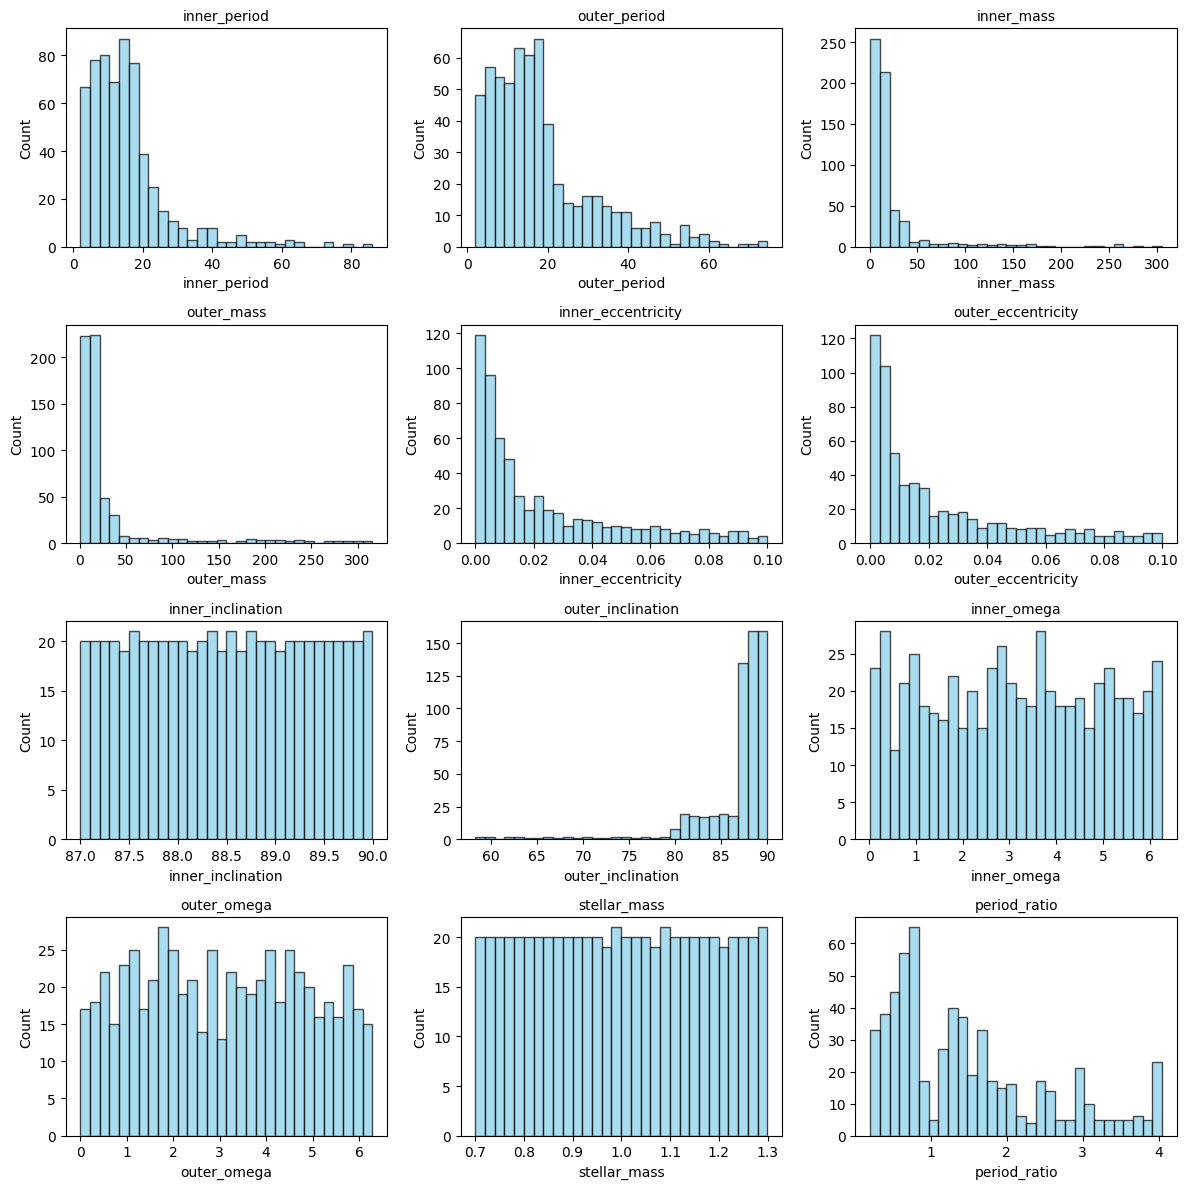

Planning to run N = 600 simulations (no product).
Sim Integrator: ias15


findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


Skipping simulation 1 due to instability: Orbits unstable: effective separation 0.001433 AU is < 0.001668 AU.
Sim Integrator: ias15
Skipping simulation 3 due to instability: Orbits unstable: effective separation 0.0008352 AU is < 0.001072 AU.
Sim Integrator: ias15
Sim Integrator: ias15


C:\Users\vikas\AppData\Local\Temp\ipykernel_30832\2302022342.py:1686: RuntimeWarning: invalid value encountered in sqrt
  amplitude_synodic_2 = 2.0 * np.sqrt(power_at_synodic_2 * variance_y2)


Sim Integrator: ias15
Sim Integrator: ias15


C:\Users\vikas\AppData\Local\anaconda3\envs\nbody\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:251: RuntimeWarning: invalid value encountered in sqrt
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)
C:\Users\vikas\AppData\Local\Temp\ipykernel_30832\2302022342.py:1636: RuntimeWarning: invalid value encountered in sqrt
  amplitude_mod_synodic = 2.0 * np.sqrt(refined_synodic_power * variance_y1)
C:\Users\vikas\AppData\Local\Temp\ipykernel_30832\2302022342.py:1683: RuntimeWarning: invalid value encountered in sqrt
  amplitude_synodic_1 = 2.0 * np.sqrt(power_at_synodic_1 * variance_y1)


Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15


C:\Users\vikas\AppData\Local\anaconda3\envs\nbody\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:251: RuntimeWarning: invalid value encountered in scalar power
  return _gamma(NH) * W * (1 - Z) ** (0.5 * (NK - 1)) * np.sqrt(0.5 * NH * Z)


Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Skipping simulation 32 due to instability: Orbits unstable: effective separation -0.0003208 AU is < 0.00107 AU.
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Skipping simulation 45 due to instability: Orbits unstable: effective separation -0.0008688 AU is < 0.001083 AU.
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15


C:\Users\vikas\AppData\Local\Temp\ipykernel_30832\2302022342.py:1638: RuntimeWarning: invalid value encountered in sqrt
  amplitude_mod_synodic = 2.0 * np.sqrt(power_synodic_before * variance_y1)


Sim Integrator: ias15


C:\Users\vikas\AppData\Local\anaconda3\envs\nbody\Lib\site-packages\astropy\timeseries\periodograms\lombscargle\_statistics.py:140: RuntimeWarning: invalid value encountered in scalar power
  return (1 - z) ** (0.5 * Nk)


Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15
Skipping simulation 61 due to instability: Orbits unstable: effective separation 0.001425 AU is < 0.001474 AU.
Skipping simulation 62 due to instability: Orbits unstable: effective separation 0.0003534 AU is < 0.001335 AU.
Sim Integrator: ias15
Sim Integrator: ias15
Sim Integrator: ias15



KeyboardInterrupt



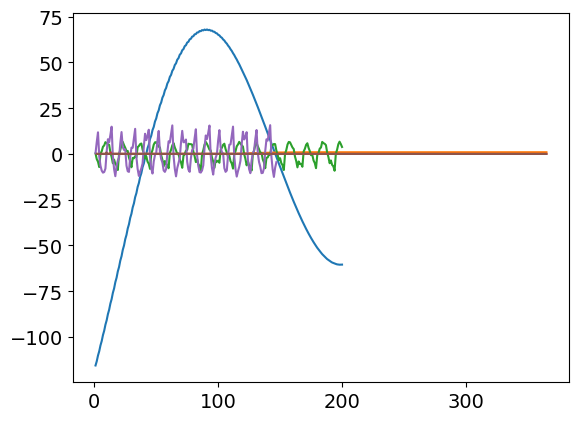

Error in callback <function flush_figures at 0x000001674AD58180> (for post_execute), with arguments args (),kwargs {}:



KeyboardInterrupt



In [5]:
import numpy as np
import random
from scipy.stats import qmc
import math

###############################################################################
# 1) Configuration
###############################################################################

N = 600  # total number of samples

# Updated resonance list per your instructions:
resonances = [
    2/1, 3/2, 4/3, 5/4, 6/5,
    1/2, 2/3, 3/4, 4/5, 5/6,
    1/3, 3/5, 5/7, 3/1, 5/3,
    7/5, 4/1, 5/2, 7/4, 1/4,
    2/5, 4/7
]

###############################################################################
# 2) Single 11D LHS
#
# Columns:
#   0 -> mass_in
#   1 -> mass_out
#   2 -> ecc_in
#   3 -> ecc_out
#   4 -> angles dimension #1  (for w_in, w_out logic)
#   5 -> angles dimension #2  (for w_in, w_out logic)
#   6 -> period_in (physically inner)
#   7 -> period_ratio
#   8 -> transiting_incl
#   9 -> nontrans_incl
#  10 -> stellar_mass
###############################################################################

D = 11
sampler = qmc.LatinHypercube(d=D)
lhs_samples = sampler.random(n=N)  # shape (N, 11) in [0,1]

# Unpack columns
u_m_in        = lhs_samples[:, 0]  # physically inner mass
u_m_out       = lhs_samples[:, 1]  # physically outer mass
u_ecc_in      = lhs_samples[:, 2]  # physically inner ecc
u_ecc_out     = lhs_samples[:, 3]  # physically outer ecc
u_angle_col1  = lhs_samples[:, 4]  # for (omega_in, omega_out) scenario
u_angle_col2  = lhs_samples[:, 5]  # for (omega_in, omega_out) random offsets
u_p_in        = lhs_samples[:, 6]  # physically inner period
u_ratio       = lhs_samples[:, 7]  # period ratio
u_incl_trans  = lhs_samples[:, 8]  # transiting planet inclination
u_incl_nontr  = lhs_samples[:, 9]  # non-transiting planet inclination
u_stellar     = lhs_samples[:,10]  # stellar mass

###############################################################################
# 3) Inverse transforms (piecewise) for each dimension
###############################################################################

#--- 3.1) Mass (physically inner): 80% uniform [0.5,20], 20% log-uniform [20,40].
def invert_mass_in(u):
    """
    80% uniform in [0.5, 20],
    20% log-uniform in [20, 40].
    """
    cutoff = 0.80
    if u < cutoff:
        frac = u / cutoff
        return 0.5 + (20.0 - 0.5)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(20.0)
        log_hi = math.log10(40.0)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 3.2) Mass (physically outer): 70% uniform [0.5,20], 30% log-uniform [20,320].
def invert_mass_out(u):
    """
    70% uniform in [0.5, 20],
    30% log-uniform in [20, 320].
    """
    cutoff = 0.70
    if u < cutoff:
        frac = u / cutoff
        return 0.5 + (20.0 - 0.5)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(20.0)
        log_hi = math.log10(320.0)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 3.3) Ecc (physically inner or outer): 30% uniform [0,0.005], 70% log-uniform [0.005,0.1].
def invert_ecc(u):
    """
    30% uniform in [0, 0.005],
    70% log-uniform in [0.005, 0.1].
    """
    cutoff = 0.30
    if u < cutoff:
        frac = u / cutoff
        return 0.0 + (0.005 - 0.0)*frac
    else:
        frac = (u - cutoff) / (1.0 - cutoff)
        log_lo = math.log10(0.005)
        log_hi = math.log10(0.1)
        log_val = log_lo + (log_hi - log_lo)*frac
        return 10.0**(log_val)

#--- 3.4) Period (physically inner) => uniform [2,20] (unchanged).
def invert_period_in(u):
    return 2.0 + (20.0 - 2.0)*u

#--- 3.5) Period Ratio => 25% uniform in [1/4,4], 75% near the listed resonances ±0.05,
#                        with NO clamping.
def invert_period_ratio(u):
    """
    25% uniform in [1/4, 4],
    75% distributed near the listed resonances ±0.05,
    with NO clamping.
    """
    frac_uni = 0.25
    if u < frac_uni:
        # 25% Uniform in [1/4, 4]
        frac = u / frac_uni
        return 0.25 + (4.0 - 0.25)*frac
    else:
        # 75% near resonances ±0.05
        cluster_u = (u - frac_uni) / (1.0 - frac_uni)
        
        n_res = len(resonances)
        block_size = 1.0 / n_res
        idx = int(cluster_u // block_size)
        if idx >= n_res:
            idx = n_res - 1
        
        local_u = (cluster_u - idx*block_size) / block_size
        r = resonances[idx]
        
        tol = 0.05
        lo = r - tol
        hi = r + tol
        width = hi - lo
        
        # Fallback if zero width (unlikely)
        if width <= 0:
            return 0.25 + (4.0 - 0.25)*local_u
        else:
            return lo + width*local_u

#--- 3.6) Stellar Mass => uniform [0.7,1.3].
def invert_stellar_mass(u):
    """
    Uniform in [0.7, 1.3].
    """
    return 0.7 + (1.3 - 0.7)*u

#--- 3.7) Transiting Incl => uniform [87,90].
def invert_incl_trans(u):
    """
    Uniform in [87, 90].
    """
    return 87.0 + (90.0 - 87.0)*u

#--- 3.8) Nontransiting Incl => 75% in [87,90], 20% in [80,87], 5% in [58,80].
def invert_incl_nontrans(u):
    """
    Piecewise distribution:
      - 75% => uniform in [87, 90]
      - 20% => uniform in [80, 87]
      - 5%  => uniform in [58, 80]
    """
    cutoff1 = 0.75  # First 75%
    cutoff2 = 0.95  # Next 20% (from 0.75 to 0.95)

    if u < cutoff1:
        # 75% in [87, 90]
        frac = u / cutoff1
        return 87.0 + (90.0 - 87.0)*frac
    elif u < cutoff2:
        # 20% in [80, 87]
        frac = (u - cutoff1) / (cutoff2 - cutoff1)
        return 80.0 + (87.0 - 80.0)*frac
    else:
        # 5% in [58, 80]
        frac = (u - cutoff2) / (1.0 - cutoff2)
        return 58.0 + (80.0 - 58.0)*frac

#--- 3.9) Angles (omega_in, omega_out) => 70% random scenario, 30% difference scenario.
def invert_omegas(u1, u2):
    """
    70% => random scenario: both angles uniform(0, 2π).
    30% => difference scenario: pick difference from {0, π/2, π, 3π/2} ±5°,
           then define w_out = w_in + difference (mod 2π).
    """
    diff_targets = [0.0, math.pi/2, math.pi, 3*math.pi/2]
    diff_pad = math.radians(5.0)  # ~0.087 rad

    cutoff = 0.70  # 70% random

    if u1 < cutoff:
        # 70% random scenario
        w_in  = 2.0*math.pi * u2
        w_out = 2.0*math.pi * random.random()
        return (w_in, w_out)
    else:
        # 30% difference scenario
        cluster_u = (u1 - cutoff) / (1.0 - cutoff)  # map [0.70,1] to [0,1]
        
        n_diff = len(diff_targets)  # =4
        block_size = 1.0 / n_diff
        idx = int(cluster_u // block_size)
        if idx >= n_diff:
            idx = n_diff - 1
        
        local_u = (cluster_u - idx*block_size) / block_size
        base_diff = diff_targets[idx]
        
        # offset in [-diff_pad, +diff_pad]
        offset = (2.0*local_u - 1.0)*diff_pad
        actual_diff = (base_diff + offset) % (2.0*math.pi)
        
        # w_in from [0,2π] using u2
        w_in = 2.0*math.pi * u2
        w_out = (w_in + actual_diff) % (2.0*math.pi)
        return (w_in, w_out)

###############################################################################
# 4) Generate final arrays by piecewise inverts
###############################################################################

m_in_array    = np.array([invert_mass_in(u)     for u in u_m_in])
m_out_array   = np.array([invert_mass_out(u)    for u in u_m_out])
ecc_in_array  = np.array([invert_ecc(u)         for u in u_ecc_in])
ecc_out_array = np.array([invert_ecc(u)         for u in u_ecc_out])

# For angles, handle in a loop because each pair depends on 2 LHS columns:
omega_in_array  = np.zeros(N)
omega_out_array = np.zeros(N)
for i in range(N):
    w_in, w_out = invert_omegas(u_angle_col1[i], u_angle_col2[i])
    omega_in_array[i]  = w_in
    omega_out_array[i] = w_out

p_in_array      = np.array([invert_period_in(u) for u in u_p_in])
ratio_array     = np.array([invert_period_ratio(u) for u in u_ratio])
stellar_mass_arr= np.array([invert_stellar_mass(u) for u in u_stellar])

incl_trans_array   = np.array([invert_incl_trans(u)   for u in u_incl_trans])
incl_nontrans_array= np.array([invert_incl_nontrans(u) for u in u_incl_nontr])

###############################################################################
# 5) Build the final physically "inner" vs "outer" arrays 
#    and also apply transiting vs. nontransiting incl logic
###############################################################################

inner_period    = np.zeros(N)
outer_period    = np.zeros(N)
inner_mass      = np.zeros(N)
outer_mass      = np.zeros(N)
inner_ecc       = np.zeros(N)
outer_ecc       = np.zeros(N)
inner_omega     = np.zeros(N)
outer_omega     = np.zeros(N)
inner_incl      = np.zeros(N)
outer_incl      = np.zeros(N)

for i in range(N):
    r = ratio_array[i]
    p_in_phys = p_in_array[i]
    
    # If ratio > 1, we keep p_in as physically inside; else swap
    if r > 1:
        # physically inside => keep arrays "as is"
        inner_period[i] = p_in_phys
        outer_period[i] = p_in_phys * r
        
        inner_mass[i]   = m_in_array[i]
        outer_mass[i]   = m_out_array[i]
        inner_ecc[i]    = ecc_in_array[i]
        outer_ecc[i]    = ecc_out_array[i]
        inner_omega[i]  = omega_in_array[i]
        outer_omega[i]  = omega_out_array[i]
        
        # Suppose physically inside => transiting, physically outside => non-trans
        inner_incl[i] = incl_trans_array[i]
        outer_incl[i] = incl_nontrans_array[i]
        
    else:
        # ratio < 1 => physically inside is "outer" in code => swap
        inner_period[i] = p_in_phys / r
        outer_period[i] = p_in_phys
        
        inner_mass[i]   = m_out_array[i]
        outer_mass[i]   = m_in_array[i]
        inner_ecc[i]    = ecc_out_array[i]
        outer_ecc[i]    = ecc_in_array[i]
        inner_omega[i]  = omega_out_array[i]
        outer_omega[i]  = omega_in_array[i]
        
        # Suppose physically inside => transiting, physically outside => non-trans
        inner_incl[i] = incl_trans_array[i]
        outer_incl[i] = incl_nontrans_array[i]

###############################################################################
# 6) param_ranges dictionary
###############################################################################

param_ranges = {
    "inner_period":       inner_period,         
    "outer_period":       outer_period,         
    "inner_mass":         inner_mass,
    "outer_mass":         outer_mass,
    "inner_eccentricity": inner_ecc,
    "outer_eccentricity": outer_ecc,
    "inner_inclination":  inner_incl,           
    "outer_inclination":  outer_incl,           
    "inner_omega":        inner_omega,          
    "outer_omega":        outer_omega,          
    "stellar_mass":       stellar_mass_arr,
    "period_ratio":       ratio_array,
    "mass_ratio":         None
}

params_to_plot = {
    "inner_period":        inner_period,
    "outer_period":        outer_period,
    "inner_mass":          inner_mass,
    "outer_mass":          outer_mass,
    "inner_eccentricity":  inner_ecc,
    "outer_eccentricity":  outer_ecc,
    "inner_inclination":   inner_incl,
    "outer_inclination":   outer_incl,
    "inner_omega":         inner_omega,
    "outer_omega":         outer_omega,
    "stellar_mass":        stellar_mass_arr,
    "period_ratio":        ratio_array
}

# Create subplots. Here we make a 4x3 grid to hold 12 histograms.
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 12))

# Flatten the axes array to iterate easily
axes = axes.flatten()

# Plot each parameter in a separate subplot
for i, (param_name, param_values) in enumerate(params_to_plot.items()):
    ax = axes[i]
    ax.hist(param_values, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(param_name, fontsize=10)
    
    # If you want to label axes, e.g. x-label / y-label:
    ax.set_xlabel(param_name)
    ax.set_ylabel("Count")

plt.tight_layout()
plt.show()

###############################################################################
# 7) Pass to your generator
###############################################################################

generate_dataset_with_multiple_params_no_product(param_ranges, epochs=200)
